In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [16]:
def covariance(x1, x2):
    sq_norm = -0.5 * sp.spatial.distance.cdist(x1, x2, 'sqeuclidean')
    return np.exp(sq_norm)

In [48]:
num_samples = 41
num_functions = 5
X = np.expand_dims(np.linspace(-4, 4, num_samples), 1)
Sigma = covariance(X, X)
ys = np.random.multivariate_normal(mean = np.zeros(num_samples), cov=Sigma, size=num_functions)
confidence = np.array([covariance([x], [x]) for x in X])
confidence = np.concatenate(confidence, axis=0)

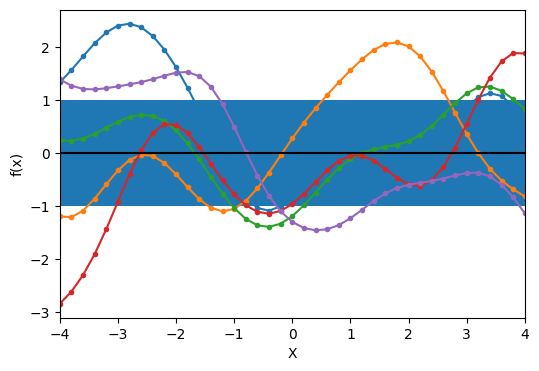

In [56]:
plt.figure(figsize=(6,4))
for i in range(num_functions):
    plt.plot(X, ys[i], linestyle='-', marker='o', markersize=3)
plt.plot(X, np.zeros(num_samples), color='0')
plt.fill_between(np.rot90(X)[0], np.rot90(confidence)[0], np.rot90(-confidence)[0])
plt.xlabel('X')
plt.ylabel('f(x)')
plt.xlim([-4,4])
plt.show()